In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zarr
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import gym_pusht


def make_env(differential_action=False, render_mode='rgb_array', pixels_based_success=False):
    # Adjust the env_id if you are using a specific repo 
    # (e.g., 'gym_pusht/PushT-v0' or a local import like PushTImageEnv)
    ENV_ID = "gym_pusht/PushT-v0"

    try:
        # We use render_mode='human' to see the replay live, 
        # or 'rgb_array' if you want to save frames.
        env = gym.make(ENV_ID, render_mode=render_mode, differential_action=differential_action, observation_width=64, observation_height=64, pixels_based_success=pixels_based_success)
        # env = gym.make(ENV_ID, render_mode="rgb_array")
        
        print(f"Successfully created environment: {ENV_ID}")
        
        # Reset to check if it works
        obs, info = env.reset()
        
    except Exception as e:
        print(f"Error creating environment: {e}")
        print("Ensure gym-pusht is installed or adjust the ENV_ID.")
        # print out the environments that gym is aware of
        print("Available environments:", gym.envs.registry.keys())
        env=None
    return env


In [3]:
# import time
# env = make_env(differential_action=True)
# for _ in range(10):
#     env.step(np.array([100, 100.0]))
#     env.render()
#     time.sleep(0.1)

In [4]:
def inspect_zarr_file(zarr_path):
    """
    Opens the Zarr file and prints the tree structure 
    to help identify the keys for states, actions, and images.
    """
    try:
        root = zarr.open(zarr_path, mode='r')
        print(f"Opened Zarr file at: {zarr_path}")
        print("-" * 20)
        print(root.tree())
        return root
    except Exception as e:
        print(f"Failed to load Zarr file. Download from https://diffusion-policy.cs.columbia.edu/data/training/ : {e}.")

        return None

# Replace with your actual path
ZARR_PATH = "/home/j/workspace/gym-pusht/demonstrations/pusht/pusht_cchi_v7_replay.zarr"
root = inspect_zarr_file(ZARR_PATH)

Opened Zarr file at: /home/j/workspace/gym-pusht/demonstrations/pusht/pusht_cchi_v7_replay.zarr
--------------------
/
 ├── data
 │   ├── action (25650, 2) float32
 │   ├── img (25650, 96, 96, 3) float32
 │   ├── keypoint (25650, 9, 2) float32
 │   ├── n_contacts (25650, 1) float32
 │   └── state (25650, 5) float32
 └── meta
     └── episode_ends (206,) int64


In [5]:
def find_offset(zarr_path, ep_idx):
    root = zarr.open(zarr_path, mode='r')
    
    # Grab the first frame
    state_0 = root['data/state'][ep_idx]    # [agent_x, agent_y, block_x, block_y, angle]
    kps_0 = root['data/keypoint'][ep_idx]   # [k1, k2, ..., k9]
    
    # Physics position of the block from state
    physics_pos = state_0[2:4]
    
    # Visual center is usually roughly the mean of all keypoints
    # OR sometimes specifically keypoint index 3 or 4 depending on the specific PushT version
    visual_pos = np.mean(kps_0, axis=0) 
    
    offset = physics_pos - visual_pos
    
    print(f"Physics Position: {physics_pos}")
    print(f"Visual Centroid:  {visual_pos}")
    print(f"Calculated Offset: {offset}")
    return offset

offset = find_offset(ZARR_PATH, 0)

Physics Position: [222.99382 381.59903]
Visual Centroid:  [217.55998 341.68152]
Calculated Offset: [ 5.433838 39.91751 ]


Loaded 206 episodes.


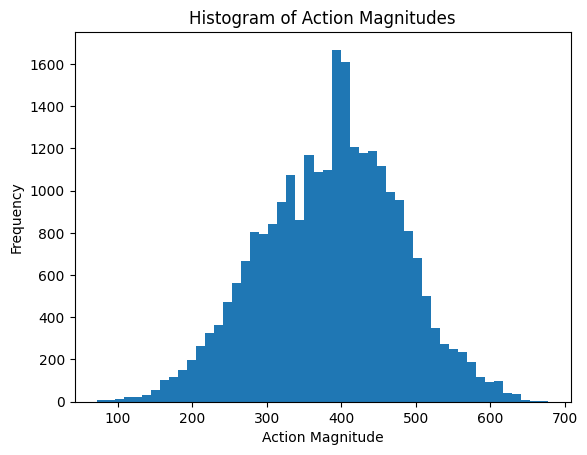

In [7]:
import collections

def load_pusht_demos(zarr_path):
    """
    Loads actions and states from Zarr and splits them into episodes
    based on 'meta/episode_ends'.
    """
    root = zarr.open(zarr_path, mode='r')
    
    # Load raw flattened arrays
    all_actions = root['data/action'][:]
    all_states = root['data/state'][:]
    episode_ends = root['meta/episode_ends'][:]
    
    episodes = []
    start_idx = 0
    
    for end_idx in episode_ends:
        # Slice the data for this specific episode
        episode_data = {
            'action': all_actions[start_idx:end_idx],
            'state': all_states[start_idx:end_idx],
            # We don't strictly need images for replay (we can render live), 
            # but you can load them here if needed:
            'img': root['data/img'][start_idx:end_idx],
            'keypoint': root['data/keypoint'][start_idx:end_idx]
        }
        episodes.append(episode_data)
        start_idx = end_idx
        
    print(f"Loaded {len(episodes)} episodes.")
    return episodes

import time
def replay_demo(env, episode_data, fps=60, differential_action=False):
    """
    Resets the environment to the demo's initial state and replays actions.
    """
    
    # 2. Force the environment state to match the demo's first frame.
    #    The state usually contains [agent_x, agent_y, block_x, block_y, block_theta].
    #    Without this, the block will be in a random spot and the actions won't make sense.
    initial_state = episode_data['state'][0]

    # 1. Reset environment for the wrappers and then for the initial state
    env.reset()
    obs, info = env.unwrapped.reset(options={"reset_to_state": initial_state})
    for _ in range(100): # takes time to arrive at the target state
        env.unwrapped._set_state(initial_state)
    env_img = env.render()
    # print(f"{initial_state=}")
    # show the initial image in episode_data
    initial_img = episode_data['img'][0].astype(np.uint8)
    final_img = episode_data['img'][-1].astype(np.uint8)

    print(f'diff position {np.linalg.norm(obs - initial_state):+1.2f}')

    # 3. Execute actions
    actions = episode_data['action']

    total_reward = 0
    
    actions = []
    if differential_action:
        # The difference between the consecutive agent positions is our differential action
        states = episode_data['state']; state_idx = 1;nsteps=0
        target_state = states[state_idx]; target_state_threshold = 1.0
        def close_enough(a, b, thresh):
            return np.linalg.norm(a - b) < thresh
        while True:
            action = target_state[0:2] - env.unwrapped.agent.position
            actions.append(action)


            obs, reward, terminated, truncated, info = env.step(action); nsteps+=1
            total_reward += reward
            env.render()

            if close_enough(env.unwrapped.agent.position, target_state[0:2], target_state_threshold):
                state_idx += 1
                if state_idx < len(states):
                    target_state = states[state_idx]
                else:
                    break
        
        print(f"Total steps taken: {nsteps}, demo length: {len(states)}")
        # repeat the last action
        obs, reward, terminated, truncated, info = env.step(action)

        # print the min and max action values
        actions = np.array(actions)
        print(f"Action stats during replay: min {actions.min(axis=0)}, max {actions.max(axis=0)}")
    else:
        for action in actions:
            # Step the environment
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            final_env_img = env.render()
            
            # Render is handled automatically by render_mode='human' in env creation
            # If you need to slow it down to be viewable:
            # plt.pause(1/fps) 
            # time.sleep(1/fps)

        # add one more action that's the same as the last action, since these demonstrations seem to end a step early
        obs, reward, terminated, truncated, info = env.step(actions[-1])
        total_reward += reward
        # for _ in range(2):
        #     obs, reward, terminated, truncated, info = env.step(actions[-1])

    final_env_img = env.render()
    toshow = np.hstack([initial_img, env_img, final_env_img])
    plt.imshow(toshow)
    plt.axis('off')
    plt.title(f"Initial State from Demo {initial_img.shape=} coverage {info['coverage']:1.2f}")
    plt.show(block=False)
    pixel_coverage = env.unwrapped._get_pixel_coverage()
    coverage = env.unwrapped._get_coverage()
    print(f"Episode replay complete. {info['coverage']=} {coverage=} vs pixel coverage {pixel_coverage:1.2f}. Total reward: {total_reward:1.2f}. {info['is_success']=}")

    return info['coverage'], pixel_coverage



# --- Usage ---
import copy, collections

differential_action = True

# 1. Load the episodes
demos = load_pusht_demos(ZARR_PATH)

# make a histogram of the actions magnitudes
all_action_magnitudes = []
for ep in demos:
    actions = ep['action']
    magnitudes = np.linalg.norm(actions, axis=1)
    all_action_magnitudes.extend(magnitudes)

plt.hist(all_action_magnitudes, bins=50)
plt.title("Histogram of Action Magnitudes")
plt.xlabel("Action Magnitude")
plt.ylabel("Frequency")
plt.show()

/home/j/workspace/dreamerv3-torch/venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Pusht force sparse reward:  False  display_cross:  False
Successfully created environment: gym_pusht/PushT-v0
Pusht force sparse reward:  False  display_cross:  False
Successfully created environment: gym_pusht/PushT-v0
diff position +89.80
Total steps taken: 394, demo length: 161
Action stats during replay: min [-20.70437229 -13.01392663], max [10.00649606 16.32305253]


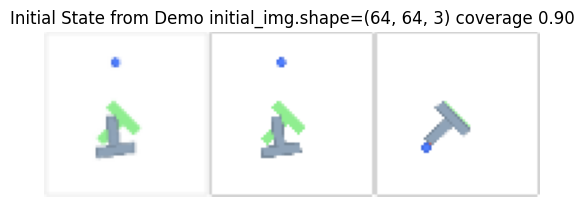

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 126.95. info['is_success']=np.False_
diff position +14.01
Total steps taken: 290, demo length: 118
Action stats during replay: min [-10.69480027 -18.51671626], max [23.26531227 16.30533635]


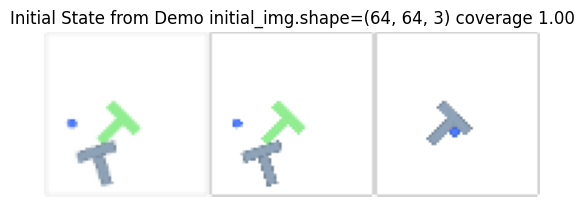

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 134.73. info['is_success']=np.True_
diff position +89.77
Total steps taken: 279, demo length: 141
Action stats during replay: min [-14.51625298 -23.28698284], max [8.57447815 9.64197707]


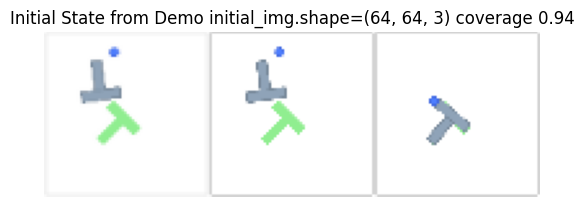

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 126.87. info['is_success']=np.False_
diff position +85.90
Total steps taken: 395, demo length: 159
Action stats during replay: min [-16.52580201 -21.96846683], max [42.41352054 19.75194415]


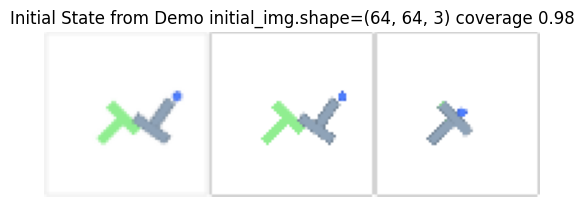

Episode replay complete. info['coverage']=np.float64(0.9805825242718447) coverage=np.float64(0.9805825242718447) vs pixel coverage 0.98. Total reward: 89.70. info['is_success']=np.True_
diff position +6.12
Total steps taken: 400, demo length: 159
Action stats during replay: min [-12.6356789  -17.72683864], max [30.683429   16.97090849]


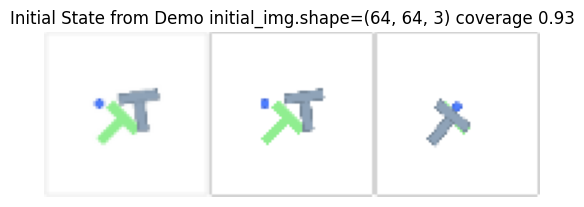

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 102.91. info['is_success']=np.False_
diff position +89.76
Total steps taken: 328, demo length: 157
Action stats during replay: min [-18.86420609 -13.25572425], max [26.91099179 16.13910281]


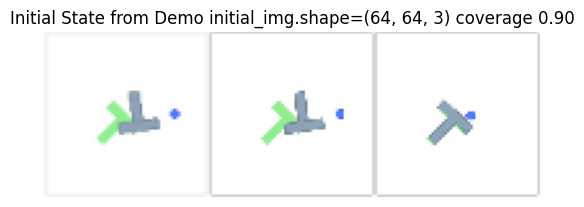

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 165.68. info['is_success']=np.False_
diff position +76.58
Total steps taken: 180, demo length: 69
Action stats during replay: min [-11.60081412 -24.9716871 ], max [6.63045433 8.42153035]


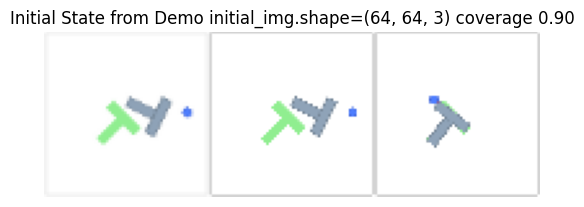

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 93.53. info['is_success']=np.False_
diff position +89.39
Total steps taken: 386, demo length: 169
Action stats during replay: min [-12.81015401 -23.44245307], max [13.87713721 19.43158283]


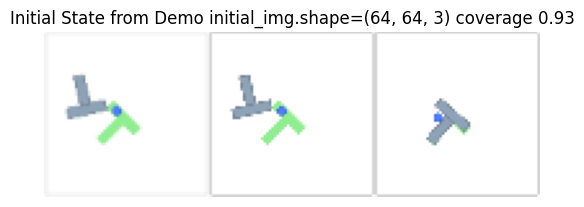

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 114.53. info['is_success']=np.False_
diff position +50.15
Total steps taken: 233, demo length: 80
Action stats during replay: min [-29.91509242 -27.608796  ], max [ 8.36610361 16.46393417]


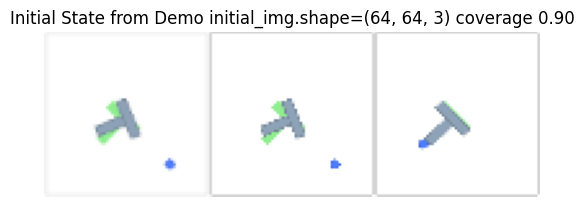

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 185.73. info['is_success']=np.False_
diff position +26.02
Total steps taken: 316, demo length: 134
Action stats during replay: min [-24.34678914 -32.50093089], max [12.17526457 10.42705414]


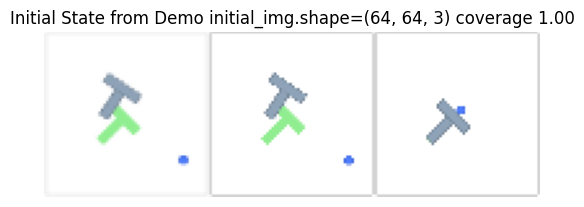

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 75.22. info['is_success']=np.True_
diff position +52.93
Total steps taken: 406, demo length: 188
Action stats during replay: min [-37.27736037 -26.4432766 ], max [24.41498357 18.14199641]


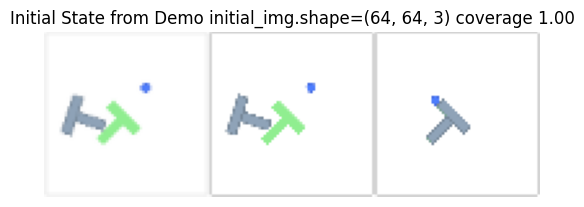

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 95.68. info['is_success']=np.True_
diff position +49.43
Total steps taken: 327, demo length: 149
Action stats during replay: min [-18.96700128  -9.19790187], max [12.59250588 18.49110865]


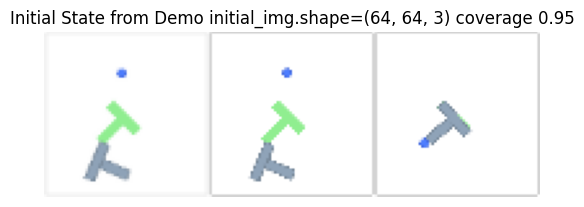

Episode replay complete. info['coverage']=np.float64(0.9514563106796117) coverage=np.float64(0.9514563106796117) vs pixel coverage 0.95. Total reward: 52.05. info['is_success']=np.True_
diff position +66.37
Total steps taken: 392, demo length: 140
Action stats during replay: min [-18.26516147 -22.83698202], max [19.43167336 19.81529089]


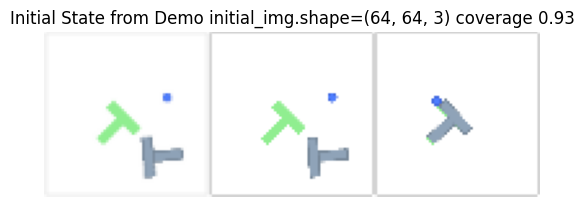

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 155.62. info['is_success']=np.False_
diff position +89.12
Total steps taken: 314, demo length: 125
Action stats during replay: min [-25.60060554 -20.31747227], max [8.15920055 9.85672459]


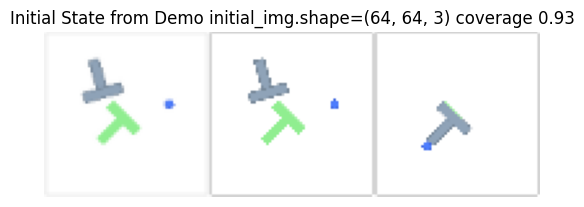

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 78.82. info['is_success']=np.False_
diff position +89.87
Total steps taken: 257, demo length: 107
Action stats during replay: min [-31.93435931 -14.29678905], max [23.439458   17.23656918]


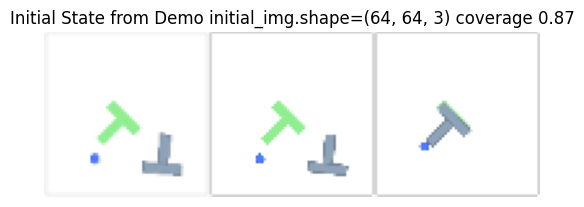

Episode replay complete. info['coverage']=np.float64(0.8737864077669903) coverage=np.float64(0.8737864077669903) vs pixel coverage 0.87. Total reward: 117.05. info['is_success']=np.False_
diff position +85.78
Total steps taken: 500, demo length: 153
Action stats during replay: min [-35.10140319 -27.3539167 ], max [24.80114586 32.0338276 ]


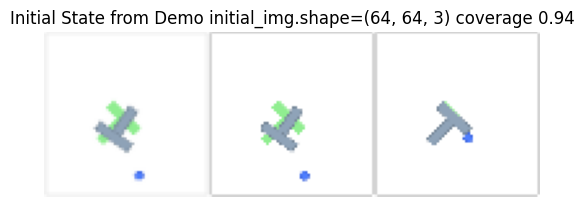

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 178.04. info['is_success']=np.False_
diff position +26.32
Total steps taken: 314, demo length: 126
Action stats during replay: min [-21.51200225 -17.0124795 ], max [36.5203267  32.98209363]


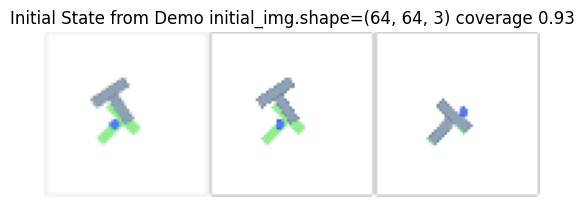

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 42.68. info['is_success']=np.False_
diff position +34.28
Total steps taken: 248, demo length: 102
Action stats during replay: min [-15.26163766  -9.74845202], max [20.42260187 23.71609042]


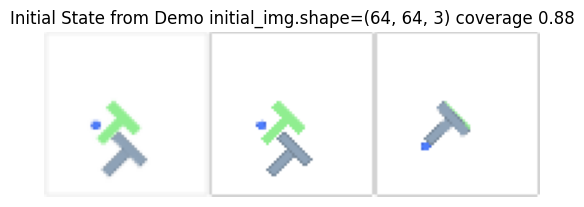

Episode replay complete. info['coverage']=np.float64(0.883495145631068) coverage=np.float64(0.883495145631068) vs pixel coverage 0.88. Total reward: 37.77. info['is_success']=np.False_
diff position +46.42
Total steps taken: 208, demo length: 86
Action stats during replay: min [-16.82052105  -8.84029892], max [ 5.766377   13.46311626]


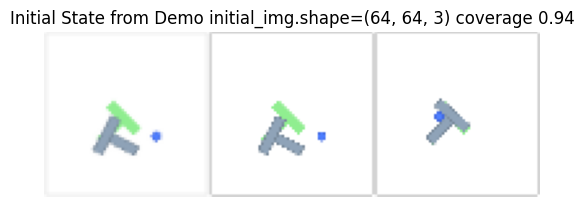

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 59.75. info['is_success']=np.False_
diff position +27.62
Total steps taken: 180, demo length: 75
Action stats during replay: min [ -7.75147613 -19.32623676], max [18.37425233 11.31106229]


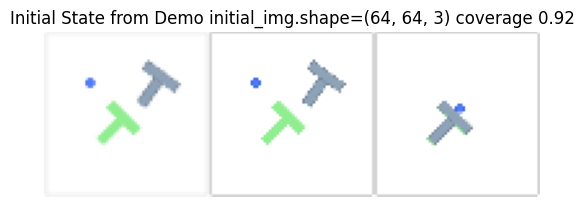

Episode replay complete. info['coverage']=np.float64(0.9223300970873787) coverage=np.float64(0.9223300970873787) vs pixel coverage 0.92. Total reward: 13.66. info['is_success']=np.False_
diff position +88.91
Total steps taken: 350, demo length: 142
Action stats during replay: min [-18.76617288 -14.5295788 ], max [ 8.60906176 18.45635781]


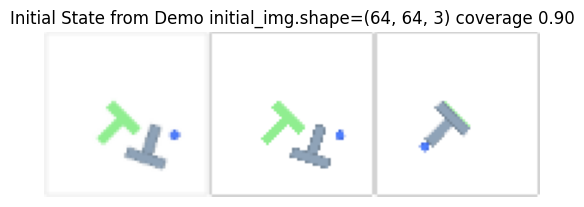

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 111.96. info['is_success']=np.False_
diff position +78.41
Total steps taken: 348, demo length: 115
Action stats during replay: min [-10.81671147 -20.85222229], max [21.16004705 11.5216968 ]


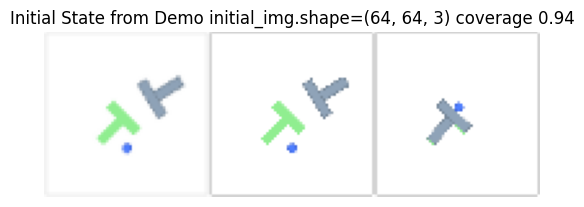

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 51.10. info['is_success']=np.False_
diff position +89.58
Total steps taken: 328, demo length: 109
Action stats during replay: min [-24.28612013 -15.30961713], max [19.37275043 22.16924726]


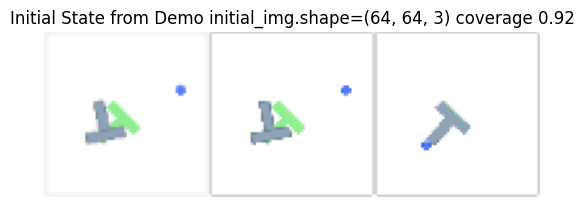

Episode replay complete. info['coverage']=np.float64(0.9223300970873787) coverage=np.float64(0.9223300970873787) vs pixel coverage 0.92. Total reward: 71.62. info['is_success']=np.False_
diff position +27.19
Total steps taken: 324, demo length: 110
Action stats during replay: min [-21.03818345 -16.74737887], max [11.61395133 18.35065737]


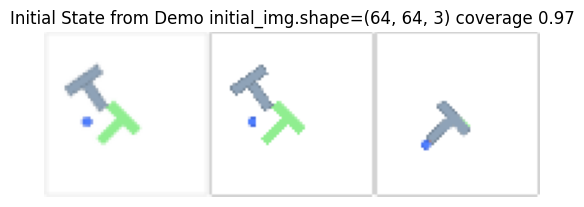

Episode replay complete. info['coverage']=np.float64(0.970873786407767) coverage=np.float64(0.970873786407767) vs pixel coverage 0.97. Total reward: 35.25. info['is_success']=np.True_
diff position +89.98
Total steps taken: 282, demo length: 98
Action stats during replay: min [-23.56135578 -12.81754299], max [20.08378751 21.74114306]


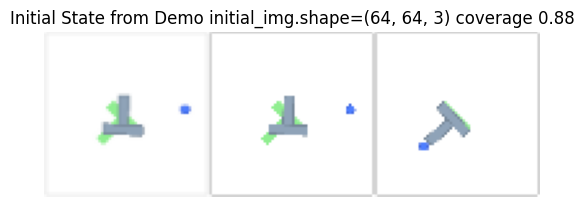

Episode replay complete. info['coverage']=np.float64(0.883495145631068) coverage=np.float64(0.883495145631068) vs pixel coverage 0.88. Total reward: 113.18. info['is_success']=np.False_
diff position +41.76
Total steps taken: 260, demo length: 133
Action stats during replay: min [-16.11909957  -9.93712946], max [17.96985633 17.12794656]


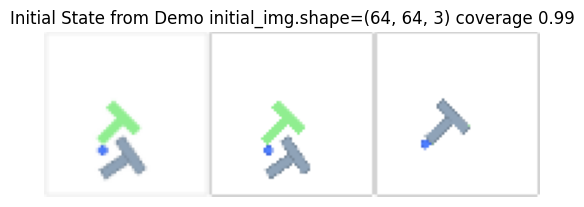

Episode replay complete. info['coverage']=np.float64(0.9902912621359223) coverage=np.float64(0.9902912621359223) vs pixel coverage 0.99. Total reward: 34.97. info['is_success']=np.True_
diff position +30.03
Total steps taken: 433, demo length: 158
Action stats during replay: min [-13.92769013 -18.60399606], max [26.03336166 20.25316914]


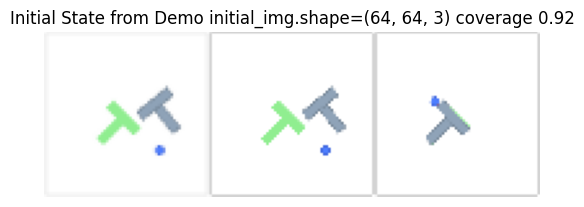

Episode replay complete. info['coverage']=np.float64(0.9223300970873787) coverage=np.float64(0.9223300970873787) vs pixel coverage 0.92. Total reward: 138.66. info['is_success']=np.False_
diff position +51.22
Total steps taken: 266, demo length: 112
Action stats during replay: min [-23.47183502  -8.62822368], max [18.30153341 22.42710996]


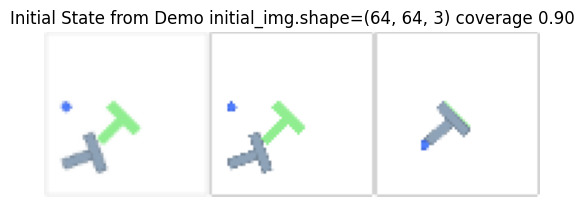

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 66.21. info['is_success']=np.False_
diff position +41.87
Total steps taken: 261, demo length: 107
Action stats during replay: min [-10.80782051 -19.76415101], max [28.321054   12.85890665]


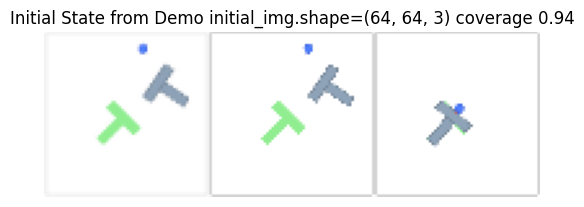

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 11.83. info['is_success']=np.False_
diff position +57.44
Total steps taken: 261, demo length: 115
Action stats during replay: min [-23.83811996  -7.63484692], max [12.82344217 18.69509243]


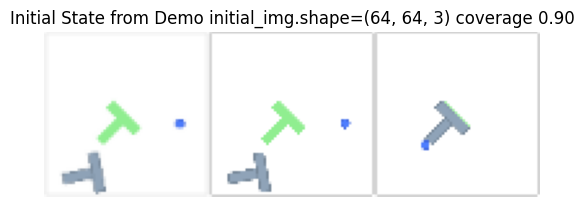

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 16.31. info['is_success']=np.False_
diff position +8.22
Total steps taken: 187, demo length: 84
Action stats during replay: min [-19.00958937  -8.57449341], max [ 5.90017156 15.59424944]


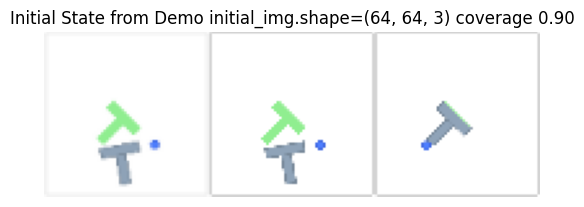

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 19.12. info['is_success']=np.False_
diff position +25.44
Total steps taken: 207, demo length: 95
Action stats during replay: min [-21.51910922  -8.23892764], max [10.64163108 10.77046597]


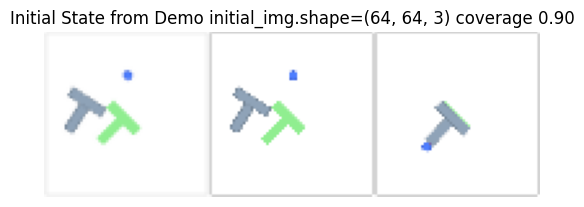

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 49.65. info['is_success']=np.False_
diff position +77.20
Total steps taken: 400, demo length: 148
Action stats during replay: min [-13.37373185 -19.50481785], max [16.22711996 23.40060709]


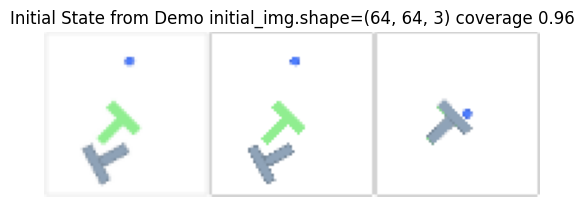

Episode replay complete. info['coverage']=np.float64(0.9611650485436893) coverage=np.float64(0.9611650485436893) vs pixel coverage 0.96. Total reward: 109.56. info['is_success']=np.True_
diff position +9.94
Total steps taken: 302, demo length: 120
Action stats during replay: min [ -9.14070642 -23.89880514], max [31.72427784 14.41686882]


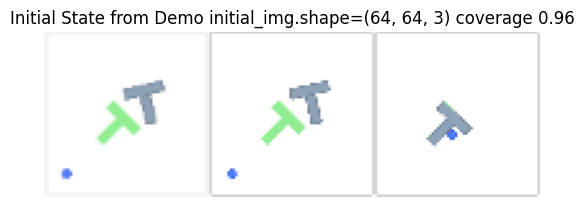

Episode replay complete. info['coverage']=np.float64(0.9611650485436893) coverage=np.float64(0.9611650485436893) vs pixel coverage 0.96. Total reward: 55.33. info['is_success']=np.True_
diff position +84.06
Total steps taken: 374, demo length: 142
Action stats during replay: min [-20.41649774 -23.31036991], max [41.85522788 16.26834341]


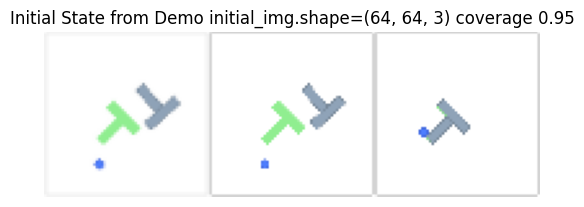

Episode replay complete. info['coverage']=np.float64(0.9514563106796117) coverage=np.float64(0.9514563106796117) vs pixel coverage 0.95. Total reward: 132.12. info['is_success']=np.True_
diff position +78.23
Total steps taken: 328, demo length: 143
Action stats during replay: min [ -9.94372494 -17.45670442], max [17.32577678 16.52613377]


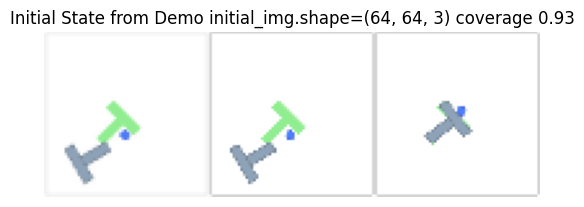

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 59.32. info['is_success']=np.False_
diff position +48.38
Total steps taken: 350, demo length: 142
Action stats during replay: min [-13.9541885  -15.19244426], max [19.06603636 20.60012016]


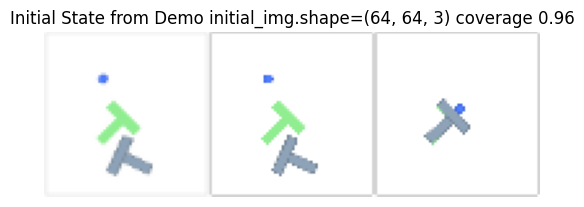

Episode replay complete. info['coverage']=np.float64(0.9611650485436893) coverage=np.float64(0.9611650485436893) vs pixel coverage 0.96. Total reward: 97.34. info['is_success']=np.True_
diff position +74.09
Total steps taken: 281, demo length: 121
Action stats during replay: min [-19.94396569 -21.33620675], max [ 9.96542005 11.40823929]


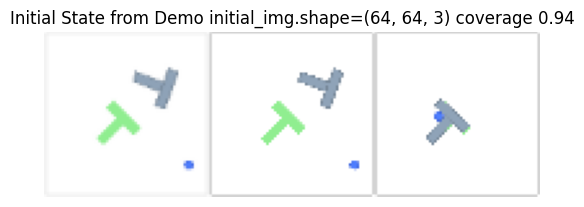

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 47.87. info['is_success']=np.False_
diff position +55.44
Total steps taken: 483, demo length: 186
Action stats during replay: min [-16.27408161 -14.59885228], max [10.63272046 20.68744106]


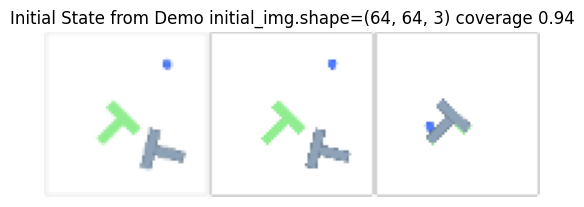

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 168.39. info['is_success']=np.False_
diff position +80.78
Total steps taken: 233, demo length: 99
Action stats during replay: min [-27.56790787  -7.08669789], max [ 8.57449341 16.01424101]


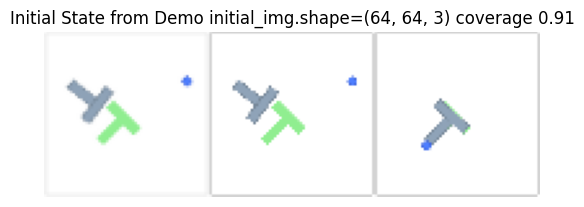

Episode replay complete. info['coverage']=np.float64(0.912621359223301) coverage=np.float64(0.912621359223301) vs pixel coverage 0.91. Total reward: 34.95. info['is_success']=np.False_
diff position +49.32
Total steps taken: 440, demo length: 139
Action stats during replay: min [-36.75855198 -23.78840057], max [18.61956177 25.15165598]


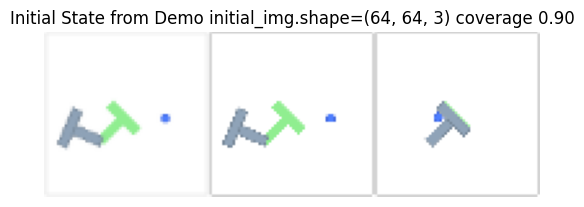

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 114.04. info['is_success']=np.False_
diff position +63.53
Total steps taken: 217, demo length: 73
Action stats during replay: min [-19.71981992 -20.55101716], max [22.77749951 18.43097309]


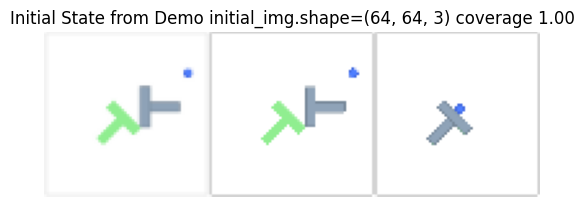

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 56.20. info['is_success']=np.True_
diff position +7.38
Total steps taken: 382, demo length: 136
Action stats during replay: min [-15.92345421 -25.53239558], max [23.67962183 16.05980139]


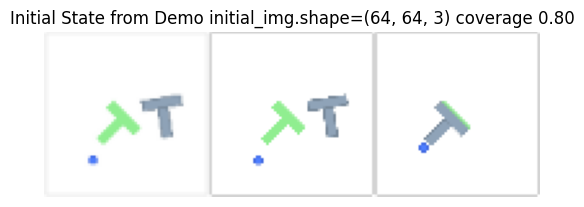

Episode replay complete. info['coverage']=np.float64(0.7961165048543689) coverage=np.float64(0.7961165048543689) vs pixel coverage 0.80. Total reward: 113.83. info['is_success']=np.False_
diff position +59.01
Total steps taken: 337, demo length: 118
Action stats during replay: min [-16.69197184  -9.98708512], max [12.30655712 22.21305569]


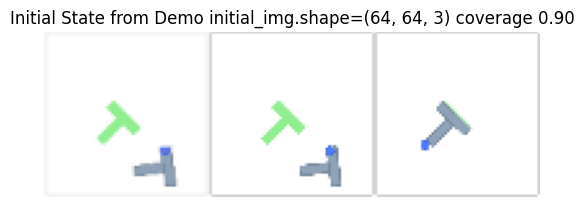

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 60.75. info['is_success']=np.False_
diff position +80.32
Total steps taken: 367, demo length: 127
Action stats during replay: min [-12.77177238 -17.89870298], max [27.647219   20.81349443]


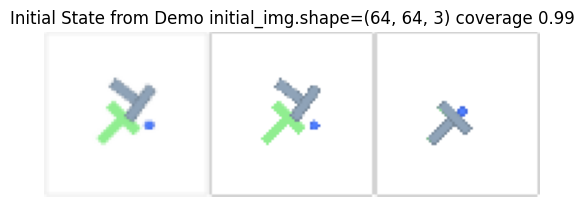

Episode replay complete. info['coverage']=np.float64(0.9902912621359223) coverage=np.float64(0.9902912621359223) vs pixel coverage 0.99. Total reward: 82.75. info['is_success']=np.True_
diff position +85.24
Total steps taken: 375, demo length: 152
Action stats during replay: min [-25.783846   -22.16838071], max [23.3525586 20.7676344]


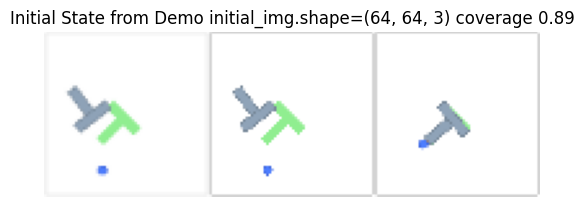

Episode replay complete. info['coverage']=np.float64(0.8932038834951457) coverage=np.float64(0.8932038834951457) vs pixel coverage 0.89. Total reward: 150.48. info['is_success']=np.False_
diff position +10.63
Total steps taken: 220, demo length: 83
Action stats during replay: min [-20.08302613 -13.53235643], max [16.30049973 20.62264559]


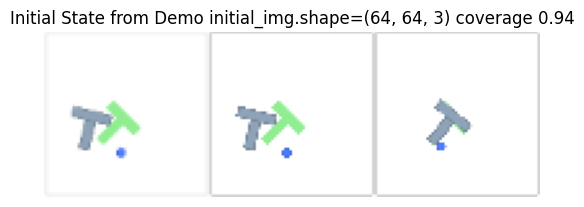

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 92.25. info['is_success']=np.False_
diff position +15.98
Total steps taken: 263, demo length: 109
Action stats during replay: min [ -7.49491668 -20.62119301], max [23.99213761 19.06219753]


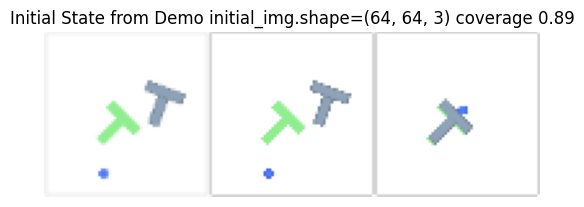

Episode replay complete. info['coverage']=np.float64(0.8932038834951457) coverage=np.float64(0.8932038834951457) vs pixel coverage 0.89. Total reward: 21.26. info['is_success']=np.False_
diff position +79.22
Total steps taken: 444, demo length: 138
Action stats during replay: min [-21.21007544 -18.37179046], max [30.67615903 22.60527541]


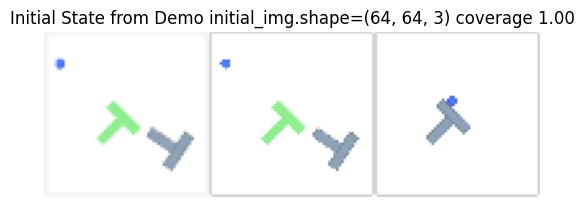

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 125.63. info['is_success']=np.True_
diff position +26.68
Total steps taken: 269, demo length: 83
Action stats during replay: min [-14.57763138 -19.04340897], max [22.0332877  18.36877247]


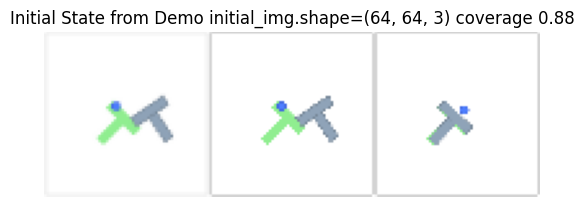

Episode replay complete. info['coverage']=np.float64(0.883495145631068) coverage=np.float64(0.883495145631068) vs pixel coverage 0.88. Total reward: 59.41. info['is_success']=np.False_
diff position +61.14
Total steps taken: 154, demo length: 69
Action stats during replay: min [-14.44108831 -11.37274722], max [3.68837585 9.80000553]


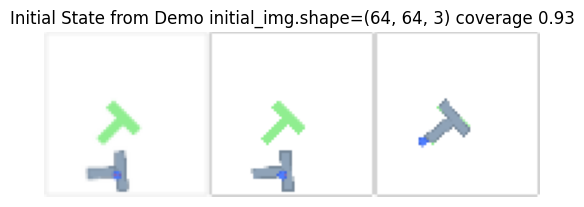

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 97.27. info['is_success']=np.False_
diff position +17.79
Total steps taken: 264, demo length: 73
Action stats during replay: min [-19.00133212 -26.27167307], max [28.39766387 12.55419641]


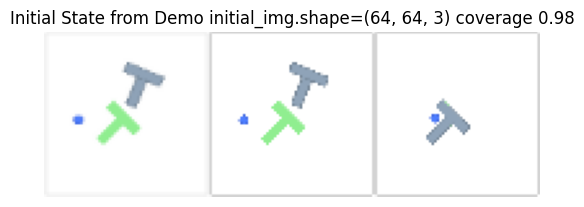

Episode replay complete. info['coverage']=np.float64(0.9805825242718447) coverage=np.float64(0.9805825242718447) vs pixel coverage 0.98. Total reward: 105.35. info['is_success']=np.True_
diff position +69.42
Total steps taken: 438, demo length: 136
Action stats during replay: min [-17.93317964 -17.12170338], max [16.90891335 11.61093337]


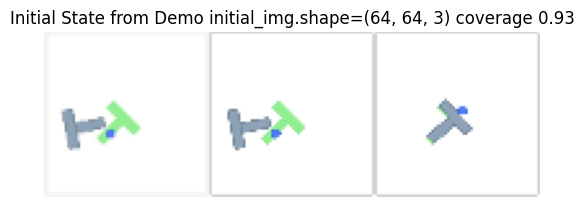

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 64.14. info['is_success']=np.False_
diff position +89.27
Total steps taken: 491, demo length: 173
Action stats during replay: min [-21.53107343 -17.98777336], max [23.97078438 14.17848028]


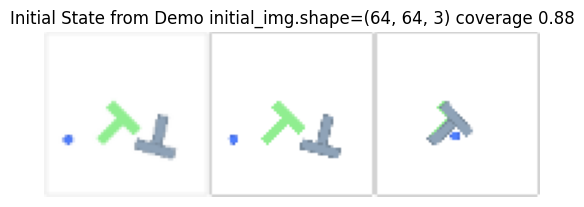

Episode replay complete. info['coverage']=np.float64(0.883495145631068) coverage=np.float64(0.883495145631068) vs pixel coverage 0.88. Total reward: 188.26. info['is_success']=np.False_
diff position +52.13
Total steps taken: 622, demo length: 205
Action stats during replay: min [-34.52206992 -29.25153879], max [23.33660838 49.3723744 ]


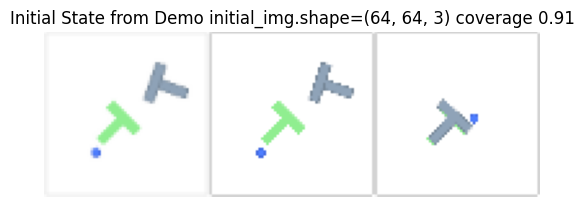

Episode replay complete. info['coverage']=np.float64(0.912621359223301) coverage=np.float64(0.912621359223301) vs pixel coverage 0.91. Total reward: 163.72. info['is_success']=np.False_
diff position +55.70
Total steps taken: 292, demo length: 106
Action stats during replay: min [-24.54784888 -16.78356028], max [9.8243842  8.47745176]


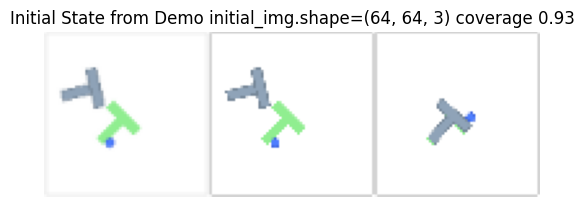

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 105.16. info['is_success']=np.False_
diff position +12.31
Total steps taken: 227, demo length: 105
Action stats during replay: min [-15.78888225  -7.4795256 ], max [ 9.45419872 25.66712541]


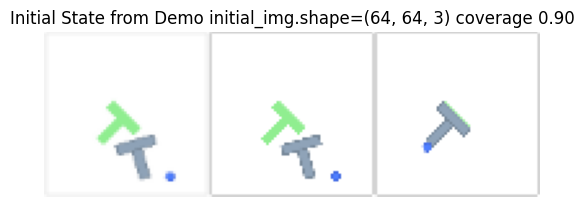

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 44.11. info['is_success']=np.False_
diff position +35.61
Total steps taken: 203, demo length: 83
Action stats during replay: min [-21.11019543  -4.56981547], max [ 9.14155416 18.00818583]


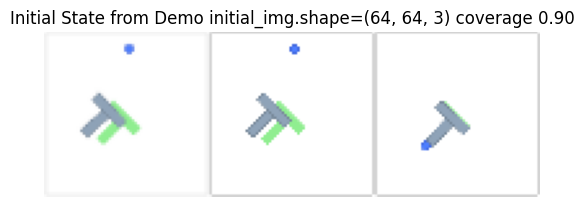

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 97.86. info['is_success']=np.False_
diff position +74.40
Total steps taken: 295, demo length: 118
Action stats during replay: min [-11.11031751 -25.51687984], max [29.11010439 13.29655876]


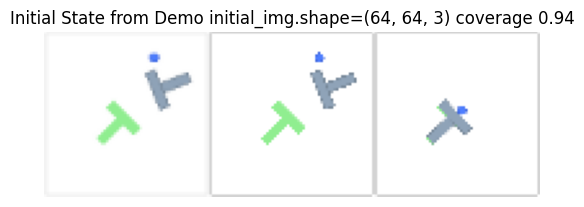

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 40.19. info['is_success']=np.False_
diff position +81.05
Total steps taken: 275, demo length: 122
Action stats during replay: min [-10.40149393  -9.07979994], max [14.36015109 12.52443225]


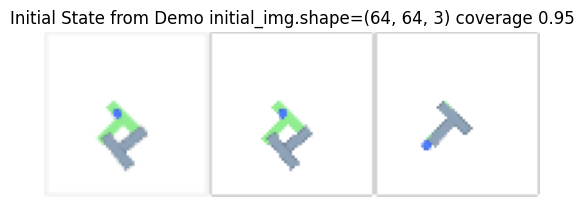

Episode replay complete. info['coverage']=np.float64(0.9514563106796117) coverage=np.float64(0.9514563106796117) vs pixel coverage 0.95. Total reward: 101.11. info['is_success']=np.True_
diff position +65.58
Total steps taken: 165, demo length: 60
Action stats during replay: min [-18.40600059  -5.39412792], max [ 8.57449341 11.61471156]


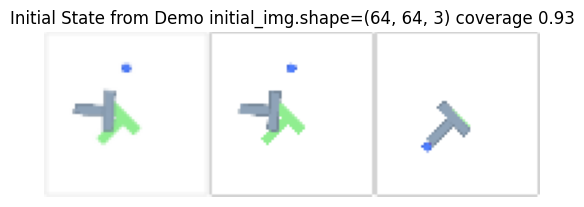

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 49.91. info['is_success']=np.False_
diff position +32.20
Total steps taken: 397, demo length: 150
Action stats during replay: min [-19.06606495 -17.95056098], max [24.47208175 21.56790598]


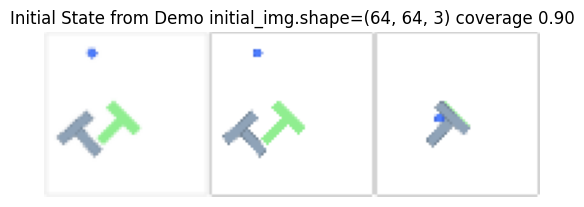

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 78.83. info['is_success']=np.False_
diff position +71.47
Total steps taken: 155, demo length: 67
Action stats during replay: min [-10.54109835  -7.3917923 ], max [ 8.0608733  16.71242645]


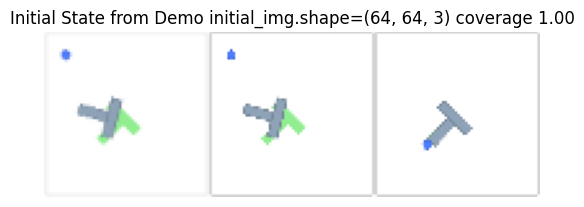

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 63.65. info['is_success']=np.True_
diff position +89.43
Total steps taken: 454, demo length: 140
Action stats during replay: min [-22.30378299 -18.34591163], max [19.10660416 26.28154097]


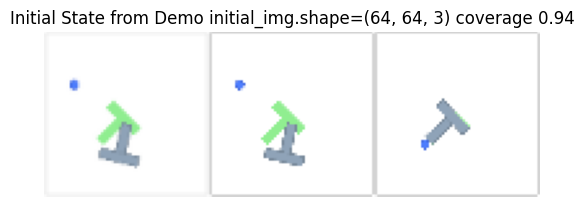

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 122.88. info['is_success']=np.False_
diff position +89.96
Total steps taken: 250, demo length: 103
Action stats during replay: min [-14.78727315  -9.26906252], max [ 9.88669306 10.47040964]


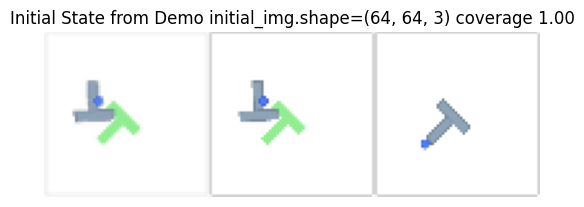

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 35.72. info['is_success']=np.True_
diff position +77.99
Total steps taken: 521, demo length: 166
Action stats during replay: min [-40.56947676 -18.96863403], max [19.52484991 19.42668293]


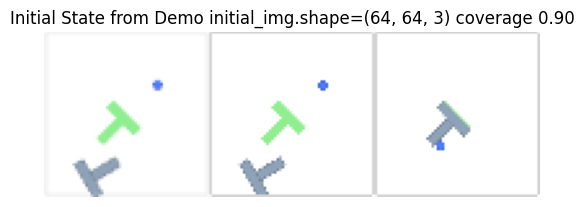

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 170.07. info['is_success']=np.False_
diff position +23.58
Total steps taken: 231, demo length: 67
Action stats during replay: min [-23.86428891 -26.26452979], max [13.66215529 12.68818476]


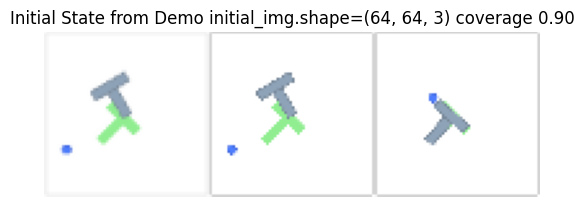

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 108.37. info['is_success']=np.False_
diff position +87.40
Total steps taken: 328, demo length: 104
Action stats during replay: min [-15.56940357 -19.11456811], max [21.77010579 18.59609559]


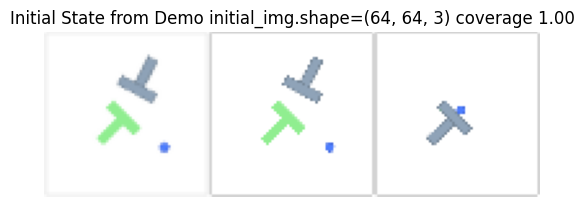

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 80.30. info['is_success']=np.True_
diff position +56.38
Total steps taken: 240, demo length: 90
Action stats during replay: min [-14.49492216  -8.47743373], max [ 6.8586075  25.63302397]


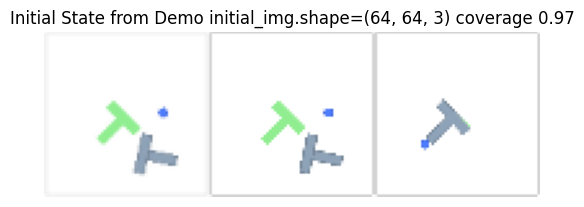

Episode replay complete. info['coverage']=np.float64(0.970873786407767) coverage=np.float64(0.970873786407767) vs pixel coverage 0.97. Total reward: 61.29. info['is_success']=np.True_
diff position +79.23
Total steps taken: 425, demo length: 150
Action stats during replay: min [-17.5385768  -15.93322705], max [15.15934844 13.08459784]


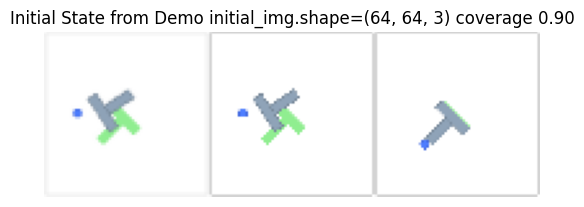

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 106.65. info['is_success']=np.False_
diff position +80.32
Total steps taken: 516, demo length: 186
Action stats during replay: min [-17.21013686 -29.35566758], max [25.58960481 33.65771684]


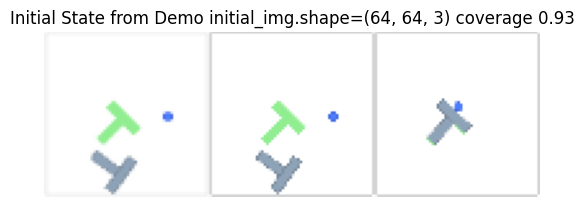

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 148.67. info['is_success']=np.False_
diff position +76.66
Total steps taken: 334, demo length: 134
Action stats during replay: min [-17.43731385 -18.62050032], max [33.15125101 15.13359728]


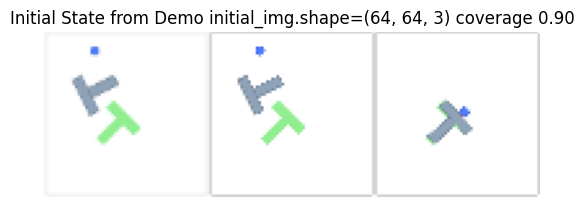

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 86.23. info['is_success']=np.False_
diff position +73.69
Total steps taken: 404, demo length: 148
Action stats during replay: min [-25.27058414 -21.80101312], max [12.92820604 22.73930925]


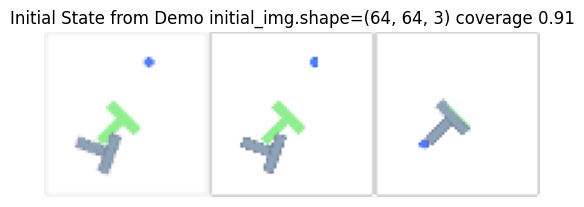

Episode replay complete. info['coverage']=np.float64(0.912621359223301) coverage=np.float64(0.912621359223301) vs pixel coverage 0.91. Total reward: 83.14. info['is_success']=np.False_
diff position +14.67
Total steps taken: 236, demo length: 112
Action stats during replay: min [-12.09513343 -23.97623545], max [21.50136519 18.45493206]


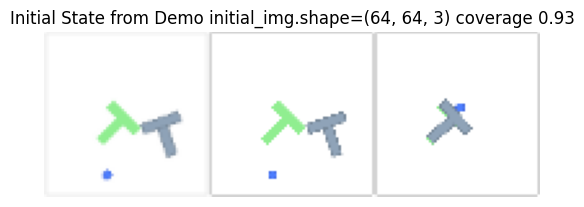

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 46.71. info['is_success']=np.False_
diff position +79.07
Total steps taken: 276, demo length: 118
Action stats during replay: min [-25.91715633 -14.05115844], max [18.78783703 15.72490969]


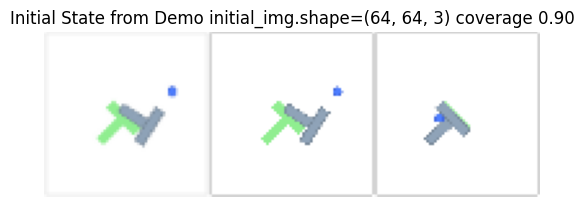

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 179.97. info['is_success']=np.False_
diff position +81.69
Total steps taken: 266, demo length: 98
Action stats during replay: min [-23.59157225 -17.52112081], max [ 9.04540891 19.7619375 ]


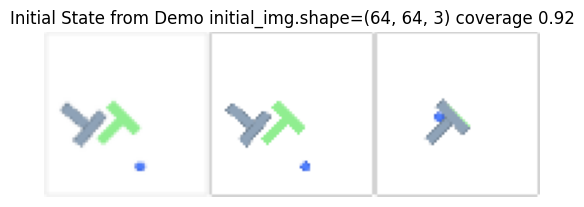

Episode replay complete. info['coverage']=np.float64(0.9223300970873787) coverage=np.float64(0.9223300970873787) vs pixel coverage 0.92. Total reward: 95.60. info['is_success']=np.False_
diff position +80.57
Total steps taken: 187, demo length: 89
Action stats during replay: min [ -8.77485101 -16.63240305], max [15.57339228  8.90461658]


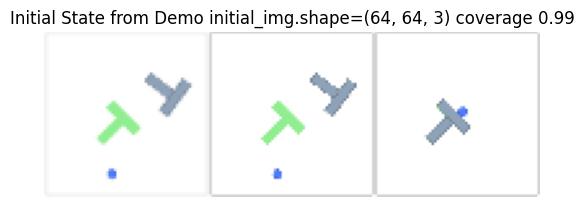

Episode replay complete. info['coverage']=np.float64(0.9902912621359223) coverage=np.float64(0.9902912621359223) vs pixel coverage 0.99. Total reward: 21.02. info['is_success']=np.True_
diff position +67.93
Total steps taken: 308, demo length: 122
Action stats during replay: min [-21.68728958 -15.31336293], max [ 9.09338434 32.6679909 ]


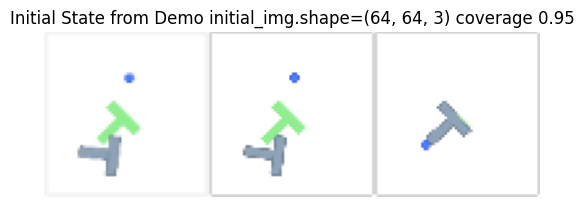

Episode replay complete. info['coverage']=np.float64(0.9514563106796117) coverage=np.float64(0.9514563106796117) vs pixel coverage 0.95. Total reward: 57.41. info['is_success']=np.True_
diff position +81.99
Total steps taken: 448, demo length: 176
Action stats during replay: min [-19.30433601 -22.01108909], max [29.04805342 19.11184609]


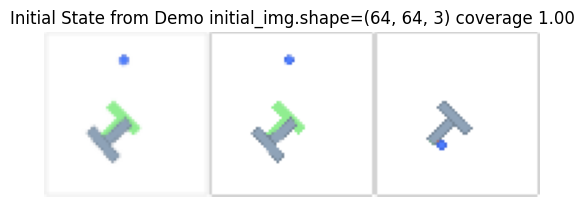

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 163.96. info['is_success']=np.True_
diff position +58.74
Total steps taken: 235, demo length: 70
Action stats during replay: min [-32.2382587  -12.84946103], max [37.96551053 20.44941959]


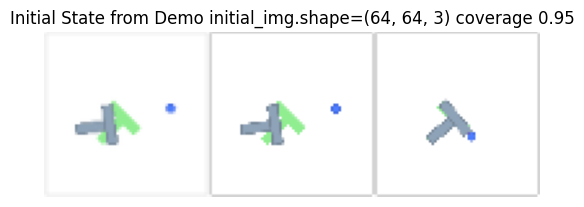

Episode replay complete. info['coverage']=np.float64(0.9514563106796117) coverage=np.float64(0.9514563106796117) vs pixel coverage 0.95. Total reward: 116.40. info['is_success']=np.True_
diff position +28.36
Total steps taken: 380, demo length: 117
Action stats during replay: min [-14.67220504 -16.35587892], max [33.7394732  22.47975537]


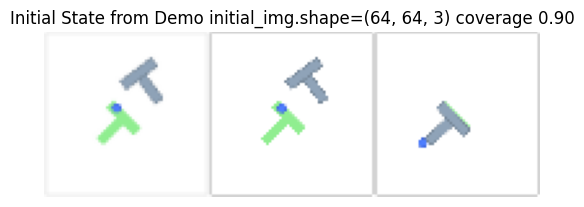

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 121.08. info['is_success']=np.False_
diff position +89.96
Total steps taken: 312, demo length: 113
Action stats during replay: min [-25.49924233 -10.28621083], max [20.0512146  17.04904646]


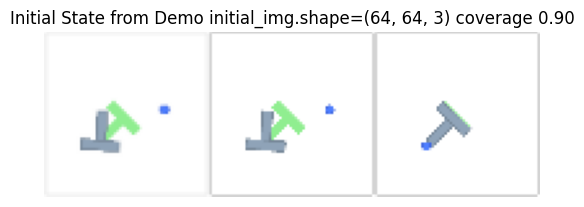

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 34.27. info['is_success']=np.False_
diff position +13.28
Total steps taken: 191, demo length: 94
Action stats during replay: min [-22.84264874  -4.05746117], max [7.68746948 9.32165487]


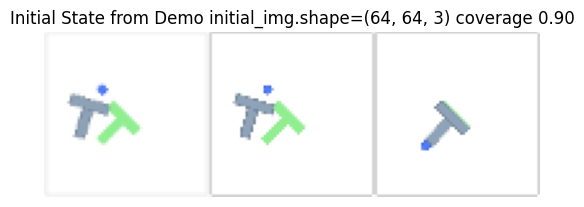

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 54.99. info['is_success']=np.False_
diff position +61.66
Total steps taken: 437, demo length: 139
Action stats during replay: min [ -9.58891347 -16.54994261], max [33.5873384  23.28378035]


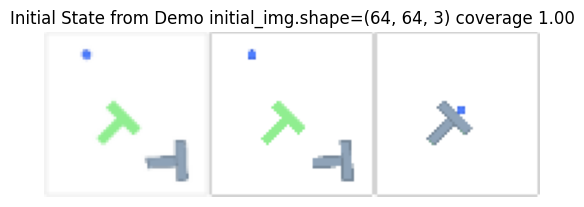

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 69.40. info['is_success']=np.True_
diff position +12.02
Total steps taken: 189, demo length: 80
Action stats during replay: min [-13.55338166 -18.9789458 ], max [30.47232663  4.85536422]


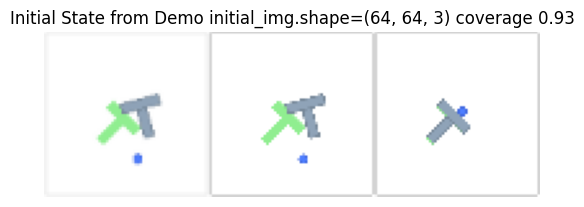

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 46.27. info['is_success']=np.False_
diff position +20.31
Total steps taken: 221, demo length: 111
Action stats during replay: min [-10.52604599 -14.43117939], max [14.38465406 17.44792792]


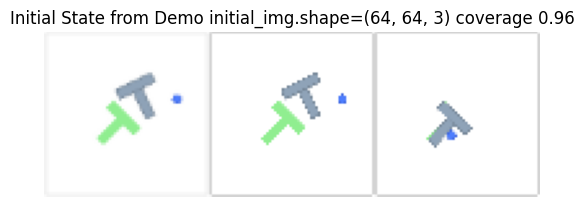

Episode replay complete. info['coverage']=np.float64(0.9611650485436893) coverage=np.float64(0.9611650485436893) vs pixel coverage 0.96. Total reward: 68.83. info['is_success']=np.True_
diff position +45.41
Total steps taken: 284, demo length: 104
Action stats during replay: min [-14.07020001 -23.2095618 ], max [26.31967959 10.758093  ]


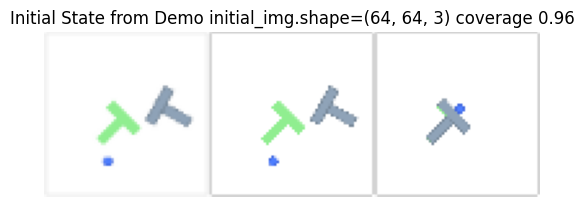

Episode replay complete. info['coverage']=np.float64(0.9611650485436893) coverage=np.float64(0.9611650485436893) vs pixel coverage 0.96. Total reward: 46.14. info['is_success']=np.True_
diff position +5.38
Total steps taken: 225, demo length: 115
Action stats during replay: min [-8.57449341 -9.48496532], max [12.24046555 14.85314871]


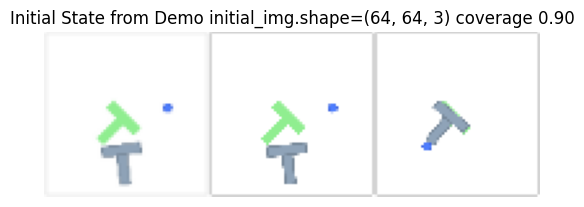

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 50.31. info['is_success']=np.False_
diff position +87.92
Total steps taken: 291, demo length: 81
Action stats during replay: min [-25.6625231  -31.32595593], max [12.36912721 21.23518899]


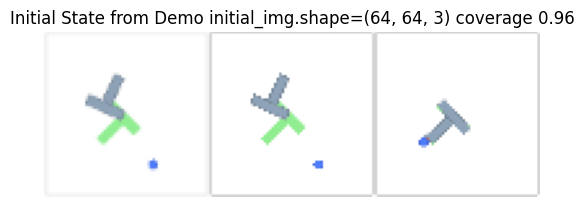

Episode replay complete. info['coverage']=np.float64(0.9611650485436893) coverage=np.float64(0.9611650485436893) vs pixel coverage 0.96. Total reward: 55.67. info['is_success']=np.True_
diff position +81.23
Total steps taken: 431, demo length: 138
Action stats during replay: min [-30.94664087 -18.15130998], max [17.13511136 18.93918185]


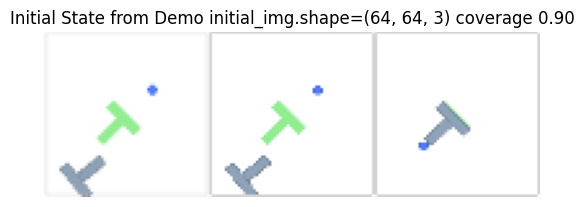

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 75.32. info['is_success']=np.False_
diff position +25.49
Total steps taken: 261, demo length: 109
Action stats during replay: min [-16.36907262 -14.69891077], max [10.90410842 13.20154889]


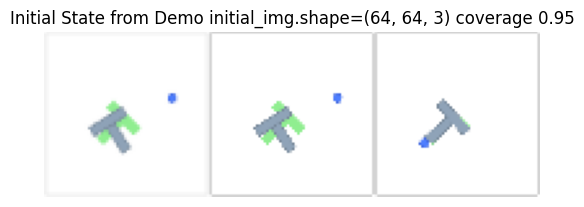

Episode replay complete. info['coverage']=np.float64(0.9514563106796117) coverage=np.float64(0.9514563106796117) vs pixel coverage 0.95. Total reward: 75.26. info['is_success']=np.True_
diff position +58.98
Total steps taken: 250, demo length: 101
Action stats during replay: min [-22.75207259 -22.56250316], max [31.27243692 22.93979152]


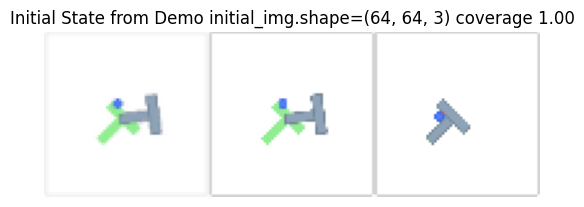

Episode replay complete. info['coverage']=np.float64(1.0) coverage=np.float64(1.0) vs pixel coverage 1.00. Total reward: 97.23. info['is_success']=np.True_
diff position +30.90
Total steps taken: 204, demo length: 78
Action stats during replay: min [-15.74758003  -7.13425476], max [ 8.48213388 18.17586147]


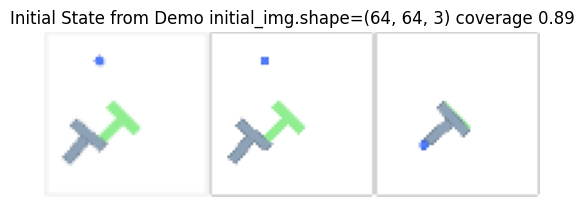

Episode replay complete. info['coverage']=np.float64(0.8932038834951457) coverage=np.float64(0.8932038834951457) vs pixel coverage 0.89. Total reward: 18.71. info['is_success']=np.False_
diff position +51.26
Total steps taken: 148, demo length: 64
Action stats during replay: min [-17.23539661  -7.43549118], max [ 4.32756351 17.58476879]


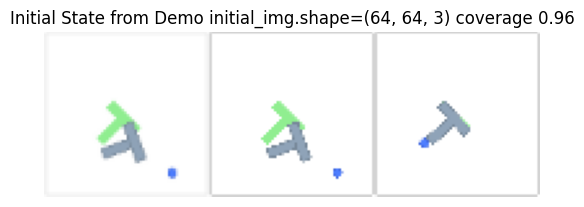

Episode replay complete. info['coverage']=np.float64(0.9611650485436893) coverage=np.float64(0.9611650485436893) vs pixel coverage 0.96. Total reward: 66.90. info['is_success']=np.True_
diff position +24.62
Total steps taken: 178, demo length: 67
Action stats during replay: min [ -9.23273608 -20.48898202], max [26.05540353 17.29253564]


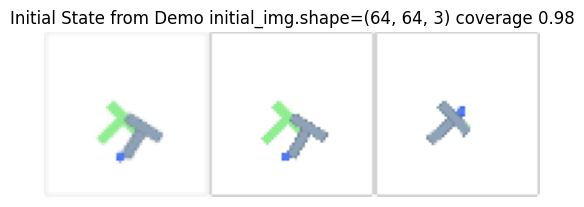

Episode replay complete. info['coverage']=np.float64(0.9805825242718447) coverage=np.float64(0.9805825242718447) vs pixel coverage 0.98. Total reward: 76.73. info['is_success']=np.True_
diff position +59.74
Total steps taken: 297, demo length: 107
Action stats during replay: min [-23.36693633 -10.24799516], max [ 9.69014472 41.55414673]


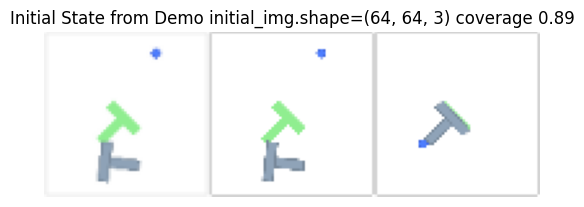

Episode replay complete. info['coverage']=np.float64(0.8932038834951457) coverage=np.float64(0.8932038834951457) vs pixel coverage 0.89. Total reward: 64.86. info['is_success']=np.False_
diff position +56.50
Total steps taken: 552, demo length: 190
Action stats during replay: min [-24.68203108 -25.62171515], max [29.62053357 22.56961855]


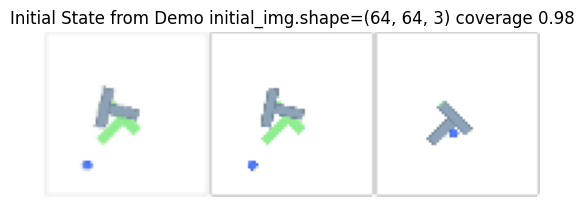

Episode replay complete. info['coverage']=np.float64(0.9805825242718447) coverage=np.float64(0.9805825242718447) vs pixel coverage 0.98. Total reward: 302.22. info['is_success']=np.True_
diff position +88.84
Total steps taken: 419, demo length: 111
Action stats during replay: min [-27.96722745 -22.95030145], max [36.68295048 44.9069677 ]


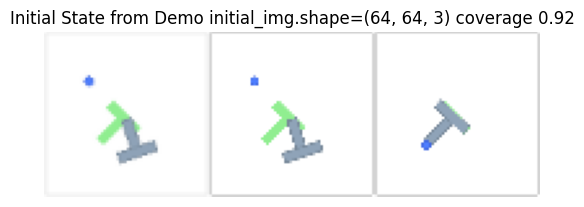

Episode replay complete. info['coverage']=np.float64(0.9223300970873787) coverage=np.float64(0.9223300970873787) vs pixel coverage 0.92. Total reward: 142.20. info['is_success']=np.False_
diff position +5.09
Total steps taken: 152, demo length: 68
Action stats during replay: min [ -7.08859324 -15.80803865], max [15.89060122 10.74866435]


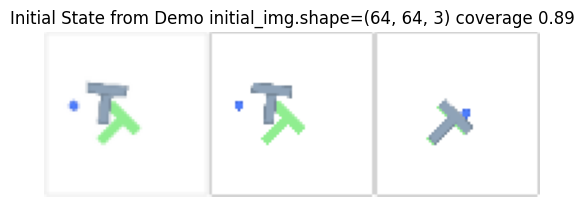

Episode replay complete. info['coverage']=np.float64(0.8932038834951457) coverage=np.float64(0.8932038834951457) vs pixel coverage 0.89. Total reward: 42.32. info['is_success']=np.False_
diff position +56.65
Total steps taken: 232, demo length: 82
Action stats during replay: min [-20.68081048  -5.91990158], max [33.59946781 23.58349197]


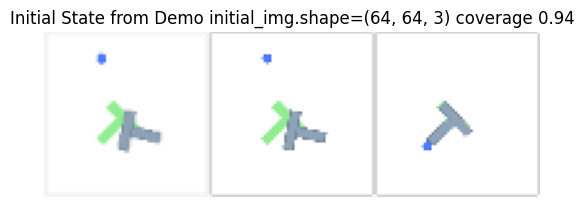

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 65.20. info['is_success']=np.False_
diff position +89.85
Total steps taken: 344, demo length: 117
Action stats during replay: min [-19.97829383 -22.27770284], max [30.47292334 15.38007981]


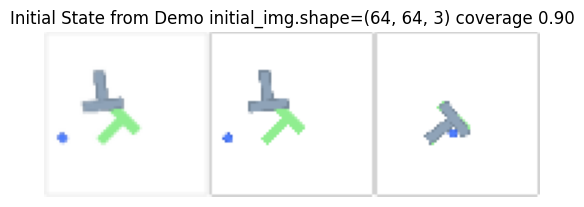

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 88.79. info['is_success']=np.False_
diff position +6.16
Total steps taken: 238, demo length: 92
Action stats during replay: min [-41.7702639  -18.56974099], max [17.14046608 16.99260359]


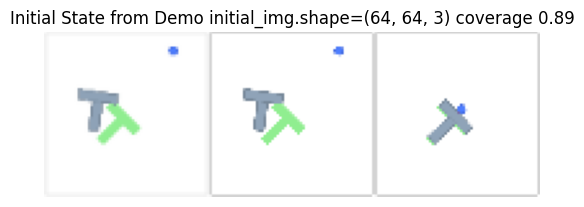

Episode replay complete. info['coverage']=np.float64(0.8932038834951457) coverage=np.float64(0.8932038834951457) vs pixel coverage 0.89. Total reward: 84.04. info['is_success']=np.False_
diff position +88.51
Total steps taken: 332, demo length: 114
Action stats during replay: min [-18.88168308 -27.5984583 ], max [12.09339147 15.58220628]


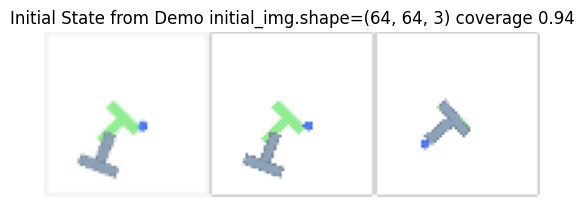

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 48.33. info['is_success']=np.False_
diff position +48.10
Total steps taken: 397, demo length: 141
Action stats during replay: min [-13.10612737 -26.33347453], max [23.07457375 21.33482346]


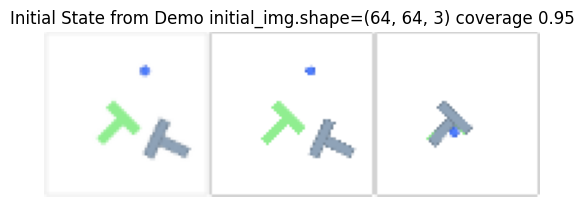

Episode replay complete. info['coverage']=np.float64(0.9514563106796117) coverage=np.float64(0.9514563106796117) vs pixel coverage 0.95. Total reward: 183.59. info['is_success']=np.True_
diff position +29.93
Total steps taken: 433, demo length: 137
Action stats during replay: min [-27.95632982 -27.58947917], max [37.86314362 21.10353548]


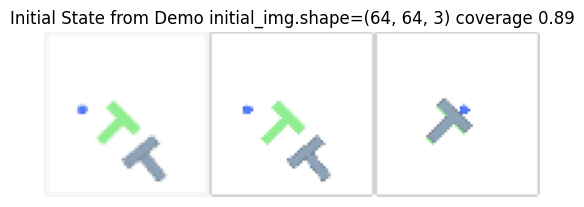

Episode replay complete. info['coverage']=np.float64(0.8932038834951457) coverage=np.float64(0.8932038834951457) vs pixel coverage 0.89. Total reward: 107.77. info['is_success']=np.False_
diff position +58.83
Total steps taken: 283, demo length: 75
Action stats during replay: min [-11.55711987 -31.84295839], max [30.80698318 28.10615448]


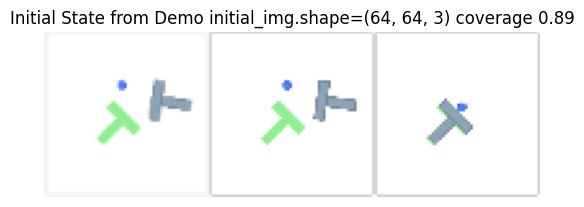

Episode replay complete. info['coverage']=np.float64(0.8932038834951457) coverage=np.float64(0.8932038834951457) vs pixel coverage 0.89. Total reward: 74.96. info['is_success']=np.False_
diff position +82.07
Total steps taken: 391, demo length: 126
Action stats during replay: min [-24.87760944 -32.28281527], max [21.94169815 21.13308052]


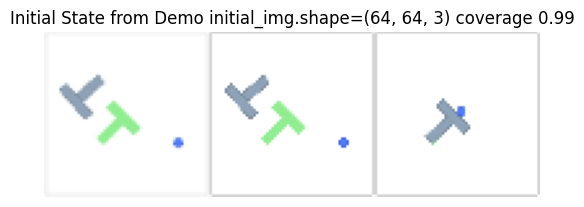

Episode replay complete. info['coverage']=np.float64(0.9902912621359223) coverage=np.float64(0.9902912621359223) vs pixel coverage 0.99. Total reward: 46.07. info['is_success']=np.True_
diff position +88.59
Total steps taken: 590, demo length: 197
Action stats during replay: min [-20.62994891 -21.81890955], max [58.82978622 29.68276746]


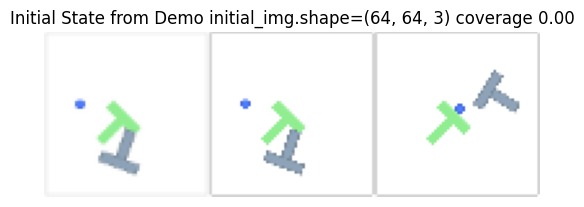

Episode replay complete. info['coverage']=np.float64(0.0) coverage=np.float64(0.0) vs pixel coverage 0.00. Total reward: 27.11. info['is_success']=np.False_
diff position +28.23
Total steps taken: 330, demo length: 112
Action stats during replay: min [-26.37128244 -23.11374476], max [24.04542611 21.26226758]


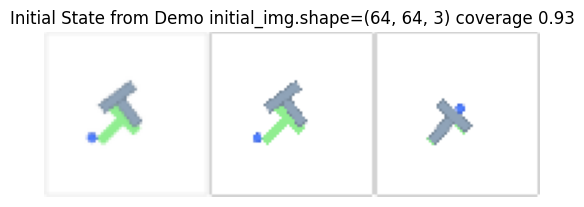

Episode replay complete. info['coverage']=np.float64(0.9320388349514563) coverage=np.float64(0.9320388349514563) vs pixel coverage 0.93. Total reward: 105.95. info['is_success']=np.False_
diff position +88.45
Total steps taken: 498, demo length: 145
Action stats during replay: min [-17.77317851 -25.07252763], max [25.4593726  21.96908221]


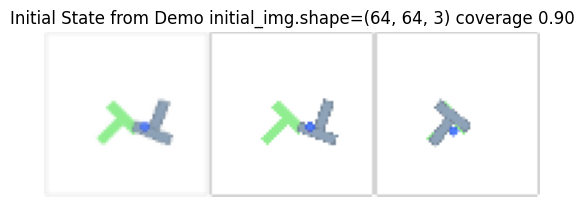

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 93.66. info['is_success']=np.False_
diff position +26.97
Total steps taken: 341, demo length: 131
Action stats during replay: min [-19.09914157 -16.46412175], max [11.36687435 18.80348142]


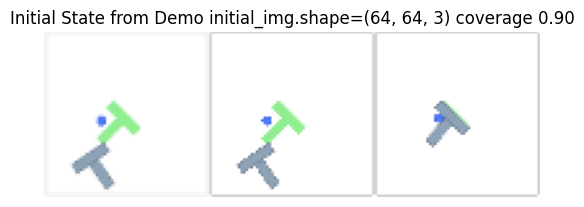

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 88.62. info['is_success']=np.False_
diff position +14.49
Total steps taken: 225, demo length: 98
Action stats during replay: min [ -8.32583773 -13.35855809], max [14.39749635 12.85521998]


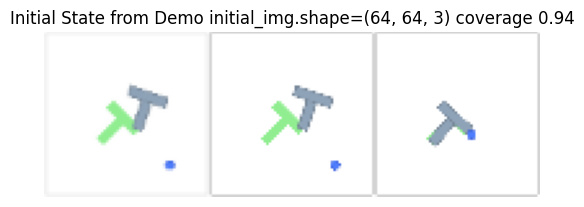

Episode replay complete. info['coverage']=np.float64(0.941747572815534) coverage=np.float64(0.941747572815534) vs pixel coverage 0.94. Total reward: 67.40. info['is_success']=np.False_
diff position +23.34


KeyboardInterrupt: 

In [8]:


env = make_env(differential_action=differential_action, pixels_based_success=True)
# resize the images if the env observation size is different from the demo image size
if env.unwrapped.observation_width != demos[0]['img'].shape[1] or env.unwrapped.observation_height != demos[0]['img'].shape[2]:
    for ep in demos:
        img = ep['img']
        if img.shape[1] != 64 or img.shape[2] != 64:
            from skimage.transform import resize
            resized_imgs = []
            for im in img:
                im_resized = resize(im, (64, 64), preserve_range=True).astype(np.uint8)
                resized_imgs.append(im_resized)
            ep['img'] = np.array(resized_imgs)

coverages = collections.defaultdict(list)
pixel_coverages = collections.defaultdict(list)
# # 2. Replay the first 3 episodes
for y_offset in [0]: #range(40,50,1):
    env = make_env(differential_action=differential_action, pixels_based_success=True)
    coverage = []
    pixel_coverage = []
    for i in range(206):
    # for i in [0]:
        # print(f"Replaying Episode {i}...")
        offset = [0, 0] # find_offset(ZARR_PATH, ep_idx=i)
        cov, pix_cov = replay_demo(env, copy.deepcopy(demos[i]), fps=120, differential_action=differential_action)
        coverage.append(cov)
        pixel_coverage.append(pix_cov)
    coverages[y_offset] = coverage
    pixel_coverages[y_offset] = pixel_coverage

# # Close env when done
# time.sleep(1)
# env.close()

In [47]:
if TUNE_TOLERANCE:=False:
        GOAL_COLOR = np.array([144, 238, 144])
        for TOLERANCE in [5.0, 10.0, 20.0, 30.0, 40.]:
                a = env.unwrapped

                # Calculate max possible green pixels
                # Render with only goal visible
                # Note: We use visualization_width/height for high res coverage, or observation_width?
                # User request: "care about the number of green pixels showing at the target rendering resoultion"
                # Assuming "target rendering resolution" means "observation resolution" unless visualize is used.
                # But coverage is used for reward, which happens every step.
                # Usually observations are small (96x96).
                pixels = a._render(visualize=False, draw_agent=False, draw_block=False)
                
                # Count green pixels
                # Using Euclidean distance in RGB space
                diff = np.linalg.norm(pixels.astype(float) - GOAL_COLOR, axis=-1)
                a._max_green_pixels = np.sum(diff < TOLERANCE)
                
                if a._max_green_pixels == 0:
                        # Should not happen unless goal is off screen or invisible
                        a._max_green_pixels = 1.0 # Avoid division by zero
                                
                # Calculate current green pixels
                pixels = a._render(visualize=False, draw_agent=True, draw_block=True)
                diff = np.linalg.norm(pixels.astype(float) - GOAL_COLOR, axis=-1)
                current_green_pixels = np.sum(diff < TOLERANCE)

                # Coverage is the proportion of goal pixels that are NOT visible (covered by block)
                # Wait, "number of green pixels showing".
                # If block covers goal, fewer green pixels show.
                # So "coverage" (success metric) is usually "how much of goal is covered".
                # If 100% covered, 0 green pixels show.
                # So coverage = 1.0 - (current / max)

                coverage = 1.0 - (current_green_pixels / a._max_green_pixels)
                print(f"Current green pixels: {current_green_pixels}, Max green pixels: {a._max_green_pixels}, Coverage: {coverage:1.2f}")

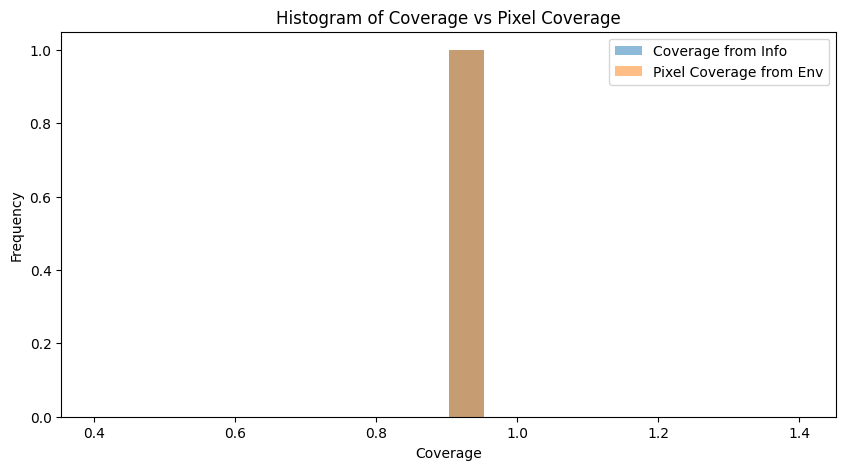

In [48]:
# histogram of coverage vs pixel coverage
c = coverages[0]
pc = pixel_coverages[0]
plt.figure(figsize=(10,5))
plt.hist(c, bins=20, alpha=0.5, label='Coverage from Info')
plt.hist(pc, bins=20, alpha=0.5, label='Pixel Coverage from Env')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.title('Histogram of Coverage vs Pixel Coverage')
plt.legend()
plt.show()

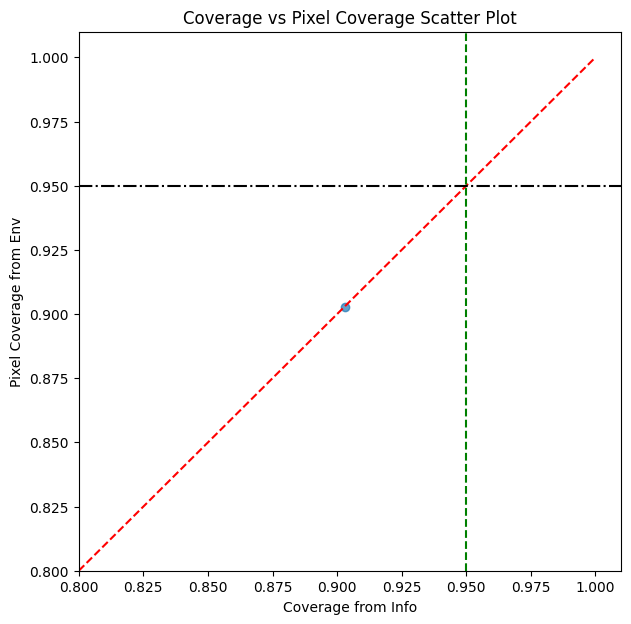

In [49]:
# plot each point coverage vs pixel coverage x,y scatter
plt.figure(figsize=(7,7))
plt.scatter(c, pc, alpha=0.7)
plt.xlabel('Coverage from Info')
plt.ylabel('Pixel Coverage from Env')
plt.title('Coverage vs Pixel Coverage Scatter Plot')

# set the x and y limits to [0,1]
plt.xlim(0.8, 1.01)
plt.ylim(0.8, 1.01)

# plot a y=x line
plt.plot([0.8, 1], [0.8, 1], color='red', linestyle='--')

# vertical line at the environment success threshold
plt.axvline(x=env.unwrapped.success_threshold, color='green', linestyle='--', label='Success Threshold')

# horizontal line at the environment success threshold
plt.axhline(y=env.unwrapped.success_threshold, color='black', linestyle='-.', label='Success Threshold')

plt.show()

In [50]:
# percentage above the success threshold
success_count = sum(1 for cov in c if cov >= env.unwrapped.success_threshold)
total_count = len(c)
success_percentage = (success_count / total_count) * 100
print(f"Success Percentage: {success_percentage:1.2f}% ({success_count}/{total_count})")

# percentage above the success threshold for pixel coverage
success_count_pc = sum(1 for cov in pc if cov >= env.unwrapped.success_threshold)
total_count_pc = len(pc)
success_percentage_pc = (success_count_pc / total_count_pc) * 100
print(f"Pixel Coverage Success Percentage: {success_percentage_pc:1.2f}% ({success_count_pc}/{total_count_pc})")

Success Percentage: 0.00% (0/1)
Pixel Coverage Success Percentage: 0.00% (0/1)


In [51]:
np.mean(coverages[0])

np.float64(0.9029126213592233)

### For the original action space
Mean with 0 extra steps: 0.89939

Mean with 1 extra steps: 0.91195

Mean with 2 extra steps: 0.90637

so these demonstrations are likely terminated a step too early. 

### For the differential action space
Mean with 1 extra steps: 0.84154

In [52]:
env = make_env()
# reset to 0s state
env.unwrapped.reset(options={"reset_to_state": np.zeros(5)})    

Pusht force sparse reward:  False  display_cross:  False
Successfully created environment: gym_pusht/PushT-v0


(array([0., 0., 0., 0., 0.]),
 {'pos_agent': array([0., 0.]),
  'vel_agent': array([0., 0.]),
  'block_pose': array([0., 0., 0.]),
  'goal_pose': array([256.        , 256.        ,   0.78539816]),
  'n_contacts': 1,
  'is_success': False,
  'coverage': 0.0})